In [14]:
from analysis_engine.statistics.spectra import per_spectra, arevalo_spectra, flatsky_spectra, spectra_base
from astropy.io import fits
from regions import Regions
import pyregion
import pymaster as nmt
import numpy as np

import os

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 250
from matplotlib.colors import LogNorm, Normalize

from scipy.signal import windows

from analysis_engine.utils import plotting
from analysis_engine.statistics.statfunc import corr, statfunc_base
from analysis_engine.statistics import statistics_base
from analysis_engine.statistics.spectra import arevalo_spectra, spectra_base, per_spectra

import astropy.units as u
from astropy.cosmology import WMAP1 as cosmo

inferno_cmap = plotting.make_bad_cmap('inferno')
bwr_cmap = plotting.make_bad_cmap('seismic')

DATA_DIR = '/home/m/Documents/science_codes/Data/Coma_sz/'
SZ_DATA = DATA_DIR + ''

COMA_REDSHIFT = 0.0231
d_A = cosmo.angular_diameter_distance(z=COMA_REDSHIFT)

khatrix, khatriy, khatrierror = (0.000461089,0.00056334,0.000717526,0.000974452,0.001333839,0.001846432),\
                                (2.89673913,3.336956522,3.798913043,4.027173913,3.586956522,2.934782609),\
                                [[0.380434783,0.434782609,0.505434783,0.586956522,0.679347826,0.657608696],
                                 [0.380434783,0.440217391,0.505434783,0.592391304,0.684782609,0.663043478]]
khatriy = [y/(1e6) for y in khatriy]
khatrierror[0] = [y/(1e6) for y in khatrierror[0]]
khatrierror[1] = [y/(1e6) for y in khatrierror[1]]
khatrix = [2.*np.pi*q for q in khatrix]

6547.014042218403 kpc 46.76438601584574 kpc/pixel


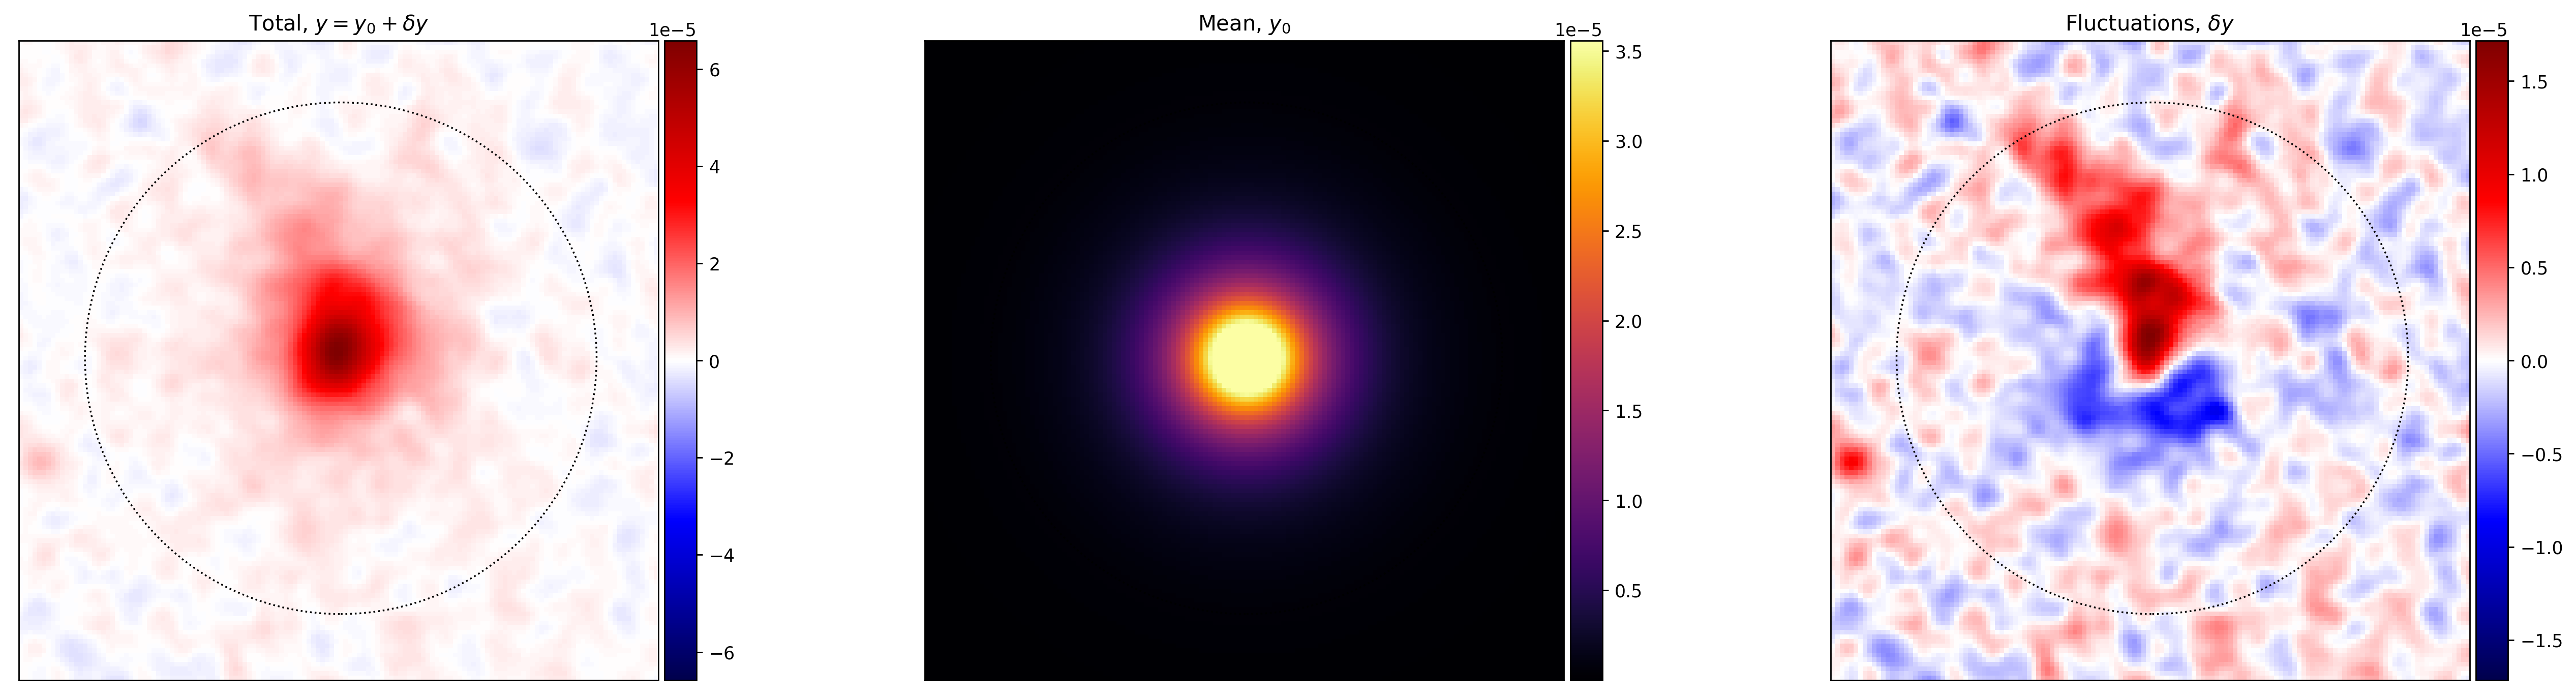

In [15]:
## FIRST MAKE THE SZ OBSERVATION
fsz = fits.open(SZ_DATA + 'map2048_MILCA_Coma_20deg_first.fits')
Ysz = fsz[1].data

## image cut
cpos = (Ysz.shape[0]//2, Ysz.shape[1]//2)
ss = 70
xmin, xmax = cpos[0]-ss, cpos[0]+ss
ymin, ymax = cpos[1]-ss, cpos[1]+ss

## my mean image needs to be convoled to the same scale as the ymap
fwhm = 10.
sig = fwhm / np.sqrt(8. * np.log(2.))

#Ysz_cut, dsz, msz_cut = Ysz[xmin:xmax, ymin:ymax], inputsfirst['e1'][0], inputsfirst['e1'][2]
#dsz_all = [inputsfirst['e1'][0], inputslast['e1'][0],(inputsfirst['e1'][0]+inputslast['e1'][0])/2]

## load data
stuff = ['first', 'last', 'G']
dsz_all = []
for i in range(len(stuff)):
    fsz = fits.open(SZ_DATA + 'map2048_MILCA_Coma_20deg_%s.fits' % stuff[i])
    Ysz = fsz[1].data
    mysz = fits.open(SZ_DATA + 'Coma_ymap_%s.fits' % stuff[i])
    msz = mysz[1].data
    msz = arevalo_spectra.img_conv_gaussian(msz, sig)
    Ysz_cut = Ysz[xmin:xmax, ymin:ymax]
    msz_cut = msz[xmin:xmax, ymin:ymax]
    dsz = Ysz_cut - msz_cut
    dsz_all.append(dsz)

## SZ DISTANCE
sz_deltdec = (fsz[1].header['CDELT2'] * u.deg).to(u.arcmin)
sz_distance_kpc = (sz_deltdec * d_A).to(u.kpc, u.dimensionless_angles())

sz_L = sz_distance_kpc.value * dsz.shape[0]
sz_L2 = [sz_L, sz_L]
sz_dx = sz_distance_kpc.value
print(sz_L, 'kpc', sz_dx, 'kpc/pixel')

## PLOT THE IMAGES
fig, ax = plotting.get_fig((1, 3))

cmin, cmax = plotting.get_symmetric_minmax(Ysz_cut)
Ysz_ax_kwargs = {'origin': 'lower', 'interpolation': 'none', 'cmap': bwr_cmap, 'vmin': cmin, 'vmax': cmax}
plotting.imshow_cbar(Ysz_cut, fig, ax[0], Ysz_ax_kwargs)

cmin, cmax = plotting.get_symmetric_minmax(msz_cut, p=0.98, sym=False)
msz_ax_kwargs = {'origin': 'lower', 'interpolation': 'none', 'cmap': inferno_cmap, 'vmin': cmin, 'vmax': cmax}
#msz_ax_kwargs = {'origin': 'lower', 'interpolation': 'none', 'cmap': inferno_cmap, 'norm': LogNorm(vmin=cmin, vmax=cmax)}
plotting.imshow_cbar(msz_cut, fig, ax[1], msz_ax_kwargs)

cmin, cmax = plotting.get_symmetric_minmax(dsz)
dsz_ax_kwargs = {'origin': 'lower', 'interpolation': 'none', 'cmap': bwr_cmap, 'vmin': cmin, 'vmax':cmax}
plotting.imshow_cbar(dsz, fig, ax[2], dsz_ax_kwargs)

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

fig.tight_layout()
ax[0].set_title('Total, $y = y_0 + \delta y$')
ax[1].set_title('Mean, $y_0$')
ax[2].set_title('Fluctuations, $\delta y$')

from matplotlib.patches import Circle
R500 = (2.62*u.Mpc).to(u.kpc).value / sz_dx
for a in ax:
    circ = Circle([n//2 for n in Ysz_cut.shape], R500, color='black', linestyle=':', fill=False)
    a.add_patch(circ)

In [16]:
deltra = (fsz[1].header['CDELT1'] * u.deg).to(u.arcmin)
deltdec = (fsz[1].header['CDELT2'] * u.deg).to(u.arcmin)
# This matches Khatri
print(deltdec, (deltdec * dsz.shape[0]).to(u.deg))

d_A = cosmo.angular_diameter_distance(z=COMA_REDSHIFT)
theta = deltdec * dsz.shape[0]
distance_kpc = (theta * d_A).to(u.kpc, u.dimensionless_angles())
print(distance_kpc, theta.to(u.arcsec))

Lkpc = distance_kpc
Larcsec = (theta.to(u.arcsec))

Lcunit = Lkpc.unit
Lc = Lkpc.value

L = [Lc, Lc]

1.7177432059087032 arcmin 4.008067480453641 deg
6547.014042218403 kpc 14429.042929633108 arcsec


Text(0.5, 0, '(degrees)')

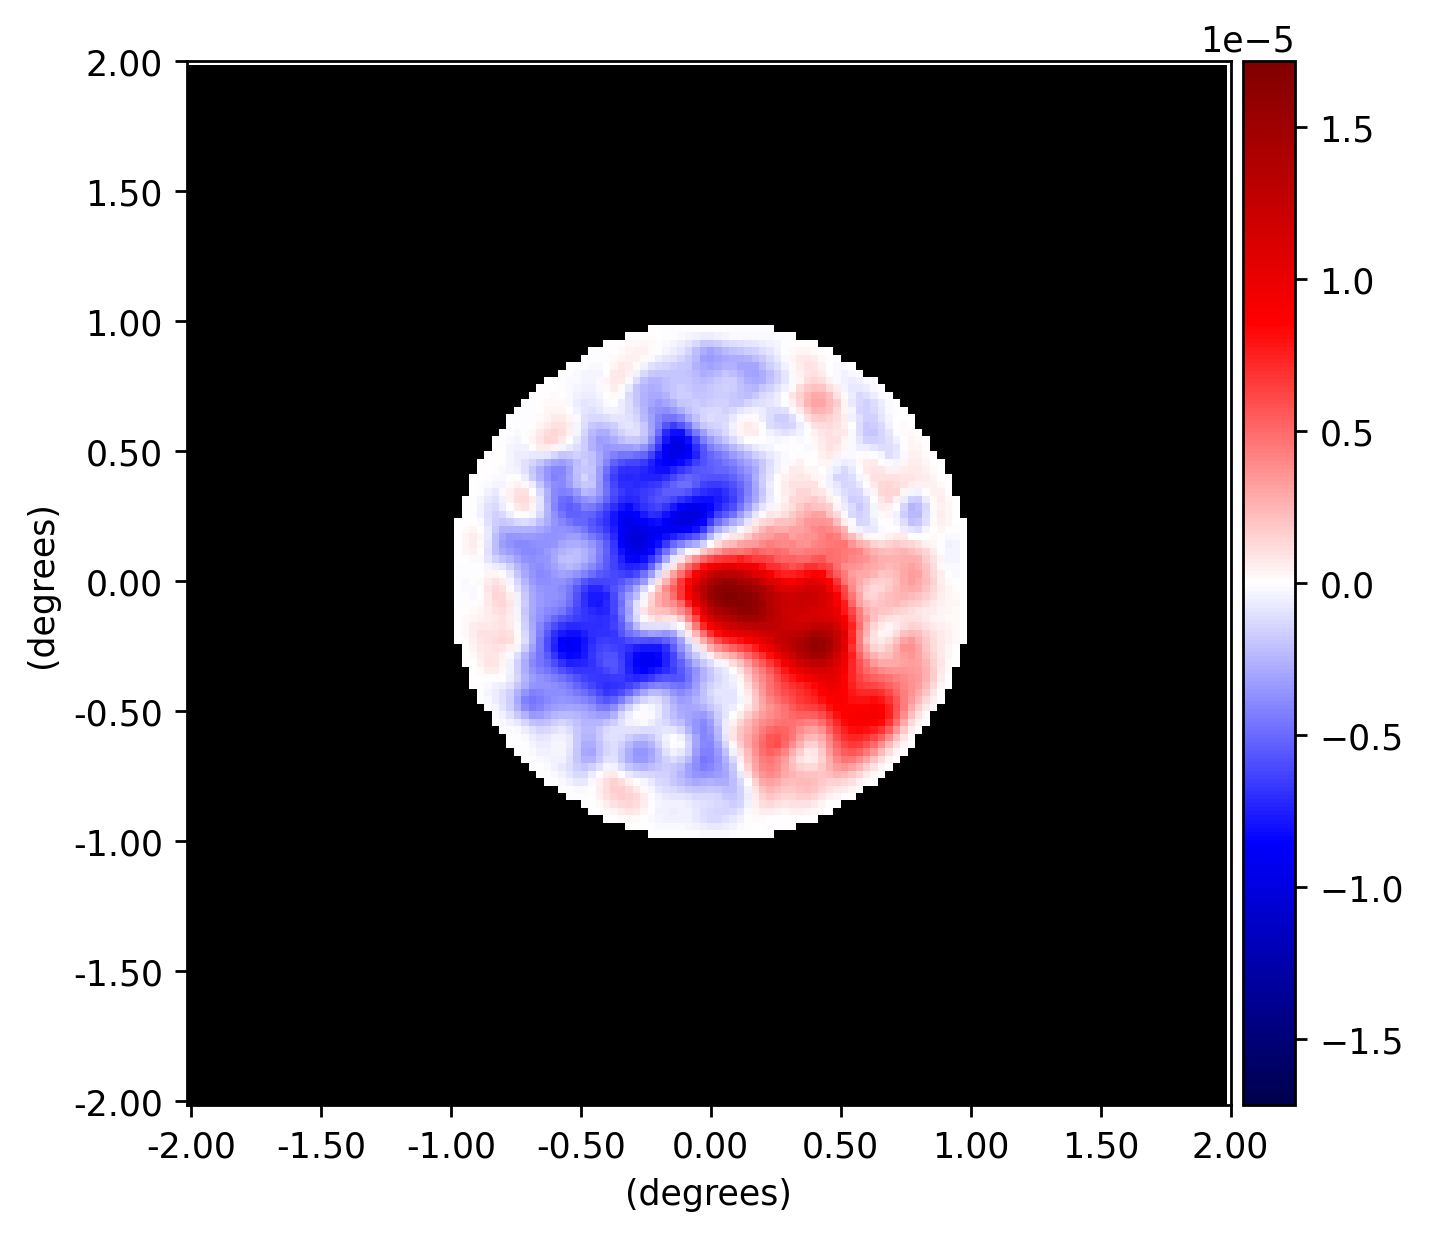

In [17]:
#Mask
Nx, Ny = np.shape(Ysz_cut)[0], np.shape(Ysz_cut)[0]
mask = np.zeros((Nx, Ny))
cen_x, cen_y = Nx / 2., Ny / 2.
cr = 60.  # radius of mask in arcmin

I, J = np.meshgrid(np.arange(mask.shape[0]), np.arange(mask.shape[1]))
dist = np.sqrt((I - cen_x) ** 2 + (J - cen_y) ** 2)
dist = dist * deltdec.value
idx = np.where(dist <= cr)
theta_ap = 15.  # apodization scale in arcmin
mask[idx] = 1 - np.exp(-9 * (dist[idx] - cr) ** 2 / (2 * theta_ap ** 2))  # described in Khatri et al.

f0 = nmt.NmtFieldFlat(L[0], L[1], mask, [dsz_all[0]])
fig, ax = plotting.get_fig((1, 1))

plt_map = f0.get_maps()[0]
plt_map[mask == 0] = np.nan

plotting.imshow_cbar(plt_map, fig, ax, dsz_ax_kwargs)

# gross
Ldeg = (deltdec * dsz.shape[0]).to(u.deg)
Lxyticks = (deltdec.to(u.deg) * dsz.shape[0]).value
xyticks = [-4.*Lxyticks/8., -3.*Lxyticks/8., -2.*Lxyticks/8., -1.*Lxyticks/8, 0, 1.*Lxyticks/8., 2.*Lxyticks/8., 3.*Lxyticks/8., 4.*Lxyticks/8.]
xyticks = ['%0.2f' % s for s in xyticks]
xytickloc = [0, 17.5, 35, 52.5, 70, 87.5, 105, 122.5, 140]
ax.set_xticks(ticks=xytickloc, labels=xyticks)
ax.set_yticks(ticks=xytickloc, labels=xyticks)
ax.set_ylabel('(degrees)')
ax.set_xlabel('(degrees)')


/home/m/.local/lib/python3.10/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/m/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


(0.0, 1e-05)

/tmp/ipykernel_7168/3387038883.py:4: RuntimeWarning: divide by zero encountered in divide
  return (2.*np.pi)/x


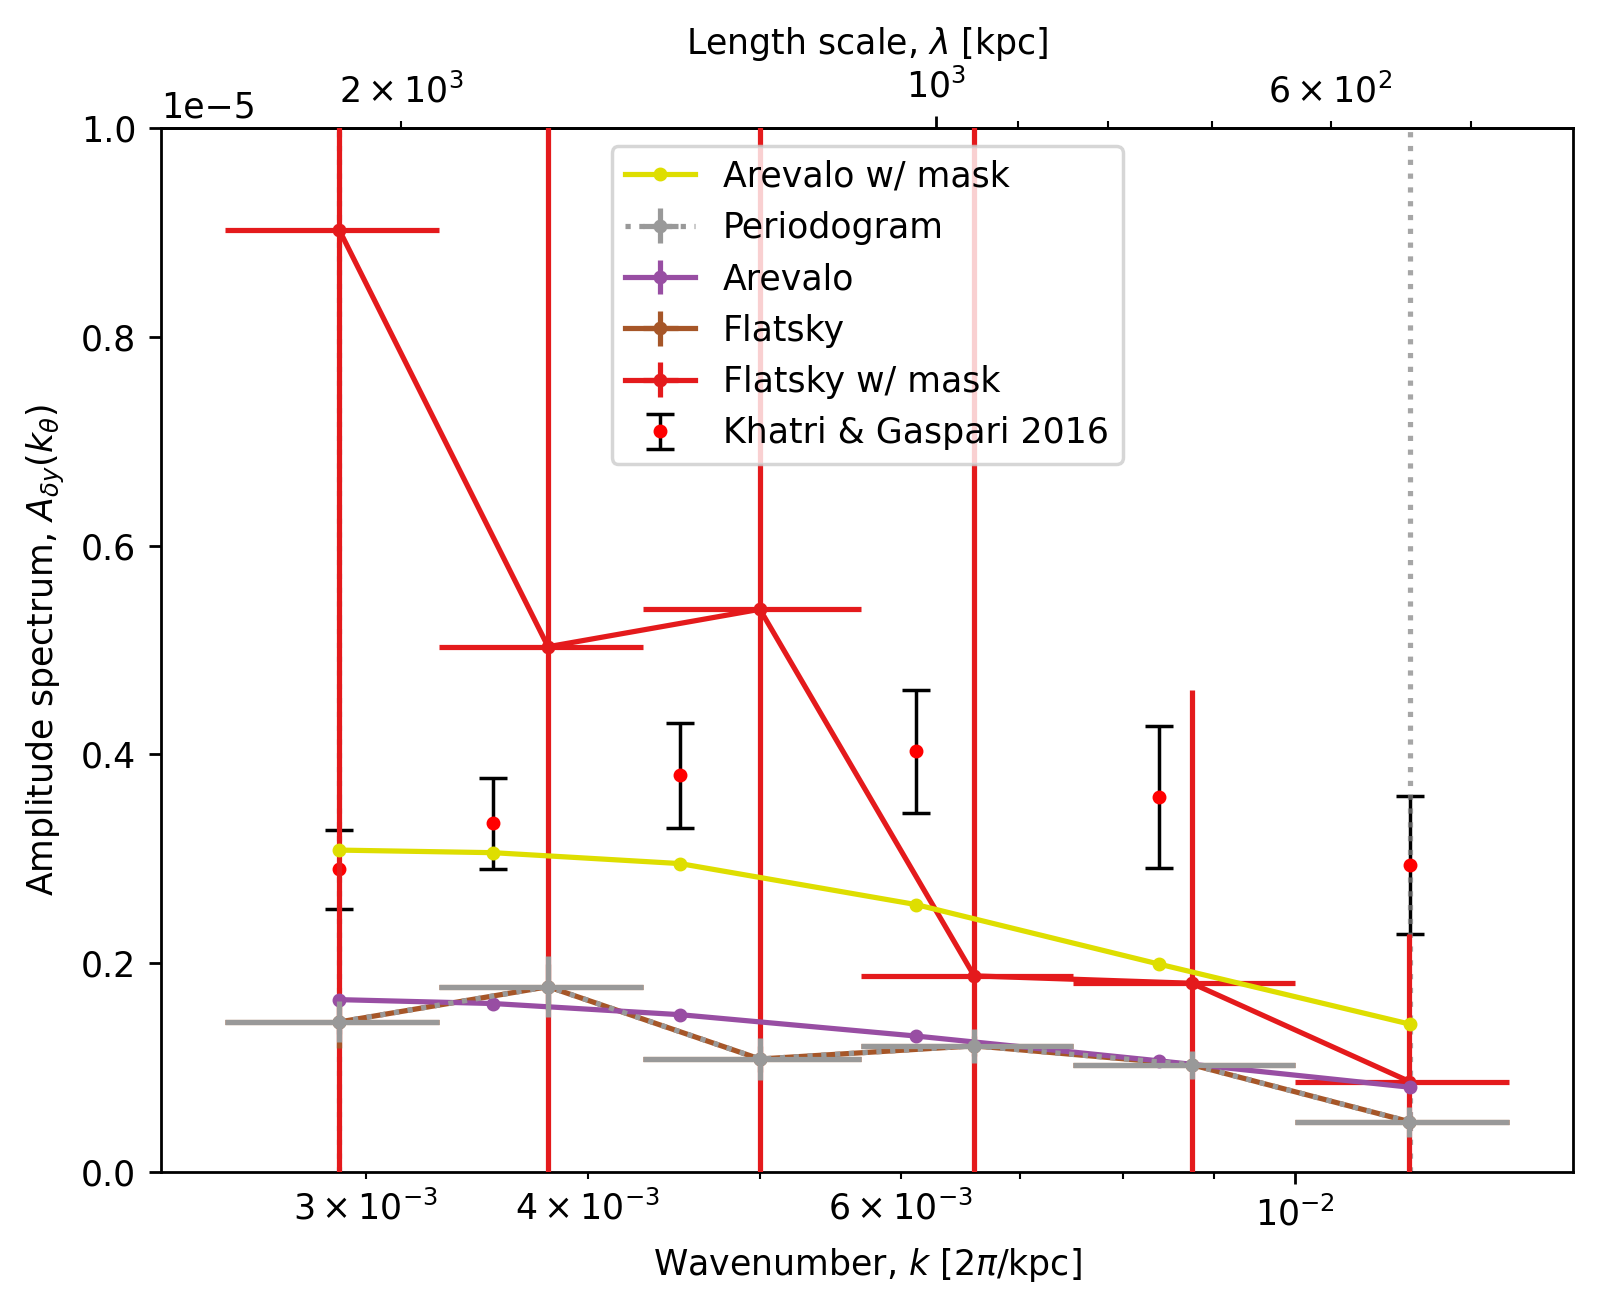

In [22]:
def k_to_l(x):
    return (2.*np.pi)/x
def l_to_k(x):
    return (2.*np.pi)/x

fig, ax = plotting.get_fig((1, 1))
ax.set_xscale('log')
ax.set_ylabel('Amplitude spectrum, $A_{\\delta y}(k_\\theta)$')

# define NBINS, LOG SPACING, and min/max bins
NBINS = 6
# min/max bins taken from khatri
# (poorly) estimate khatri (half) bin width for edge bins
dkhatri = np.diff(khatrix)/2.
# magic number is magic to get edge bins matching; no actual reasoning here...
# other bins don't match because khatri is doing fuck knows with his bin spacings...
# this creates an overlapping bin though...
minb, maxb = khatrix[0]-dkhatri[0]-1.2e-4, khatrix[-1]+dkhatri[-1]
LOG_SPACE = True
HALF_BIN = None

first = dsz_all[0]
last = dsz_all[1]
N = first.shape[0]

dk = 2. * np.pi / L[0]

_, db, _ = statistics_base.get_bins(minb, maxb, NBINS, log_space=LOG_SPACE, max_half_bin_width=HALF_BIN)

# old periodogram code you did
k3_3, fek3_3 = per_spectra.modal_spectrum(first, ar2=last, lenn=L)
k3, fek3, std3 = spectra_base.spectrum_integrate(k3_3, fek3_3, spec_type='modal', lenn=L, bin_center=True, log_space=LOG_SPACE, num_bins=NBINS, min_bin=minb, max_bin=maxb, ignore_nan=True, cut_excess=True, max_half_bin_width=HALF_BIN)
amp3 = abs((k3 ** 2) * fek3 / (2. * np.pi)) ** (1./2.)
astd3 = 0.5 * k3**2 / (2. * np.pi) / amp3 * std3
ax.errorbar(k3, np.abs(amp3), astd3, db, marker='.', color=plotting.CB_color_cycle[6], label='Periodogram', zorder=7, linestyle=':') 

# Arevalo
# atleast for arevalo, we can calculate at exactly the same points as khatri, but there is no notion [yet] to minimize the error
# by binning across more 'wavenumbers'
lags = arevalo_spectra.k_to_discrete_lags(np.array(khatrix), N, L=L[0])
k2, fek2 = arevalo_spectra.modal_spectrum(first, ar2=last, lenn=L, lags=lags)
amp2 = abs((k2**2) * fek2 / (2. * np.pi))**(1./2.)
std2 = np.zeros_like(amp2)
ax.errorbar(k2, np.abs(amp2), std2, marker='.', color=plotting.CB_color_cycle[5], label='Arevalo', zorder=6)                              

# Flatsky
k1, fek1, std1 = flatsky_spectra.modal_spectrum(first, ar2=last, lenn=L, min_bin=minb, max_bin=maxb, log_space=LOG_SPACE, nbins=NBINS, max_half_bin_width=HALF_BIN)
amp1 = abs((k1 ** 2) * fek1 / (2. * np.pi)) ** (1./2.)
#std1 = std1 / np.sqrt(2. * np.pi * k1 * dk**2)
astd1 =  0.5 * k1**2 / (2. * np.pi) / amp1 * std1
ax.errorbar(k1, np.abs(amp1), astd1, db, marker='.', color=plotting.CB_color_cycle[4], label='Flatsky', zorder=5)

# Arevalo Mask
k2, fek2 = arevalo_spectra.modal_spectrum(first*mask, ar2=last*mask, exp1=mask, exp2=mask, lenn=L, lags=lags)
amp2 = abs((k2**2) * fek2 / (2. * np.pi))**(1./2.)
ax.plot(k2, np.abs(amp2), marker='.', color=plotting.CB_color_cycle[8], label='Arevalo w/ mask', zorder=9)

# Flatsky Mask
k4, fek4, std4 = flatsky_spectra.modal_spectrum(dsz_all[0], ar2=dsz_all[1], lenn=L, mask=mask, min_bin=minb, max_bin=maxb, log_space=True, nbins=NBINS, max_half_bin_width=HALF_BIN)
amp4 = abs((k4 ** 2) * fek4 / (2. * np.pi))**(1./2.)
#std4 = np.sqrt(2. * np.pi * k4 * dk**2)
astd4 =  0.5 * k4**2 / (2. * np.pi) / amp4 * std4
ax.errorbar(k4, np.abs(amp4), astd4, db, marker='.', color=plotting.CB_color_cycle[7], label='Flatsky w/ mask', zorder=3)

# Khatri
ax.errorbar(khatrix, khatriy, yerr=(khatrierror), fmt='r.',ecolor='black',elinewidth=1,capsize = 4, label='Khatri & Gaspari 2016')

ax.legend()
ax.set_xlabel('Wavenumber, $k$ [$2 \pi$/%s]' % Lcunit)
fig.subplots_adjust(wspace=0.)

# inbetween scales selected by khatri
ax.axvline(khatrix[0], linestyle=':', color='gray', alpha=0.7)
ax.axvline(khatrix[-1], linestyle=':', color='gray', alpha=0.7)

ax2 = ax.secondary_xaxis('top', functions=(k_to_l, l_to_k))
ax2.set_xlabel('Length scale, $\lambda$ [%s]' % Lcunit)

ax.set_ylim((0, 10e-6))

Text(0.5, 0, 'Length scale, $\\lambda$ [kpc]')

/tmp/ipykernel_7168/3117251336.py:4: RuntimeWarning: divide by zero encountered in divide
  return (2.*np.pi)/x


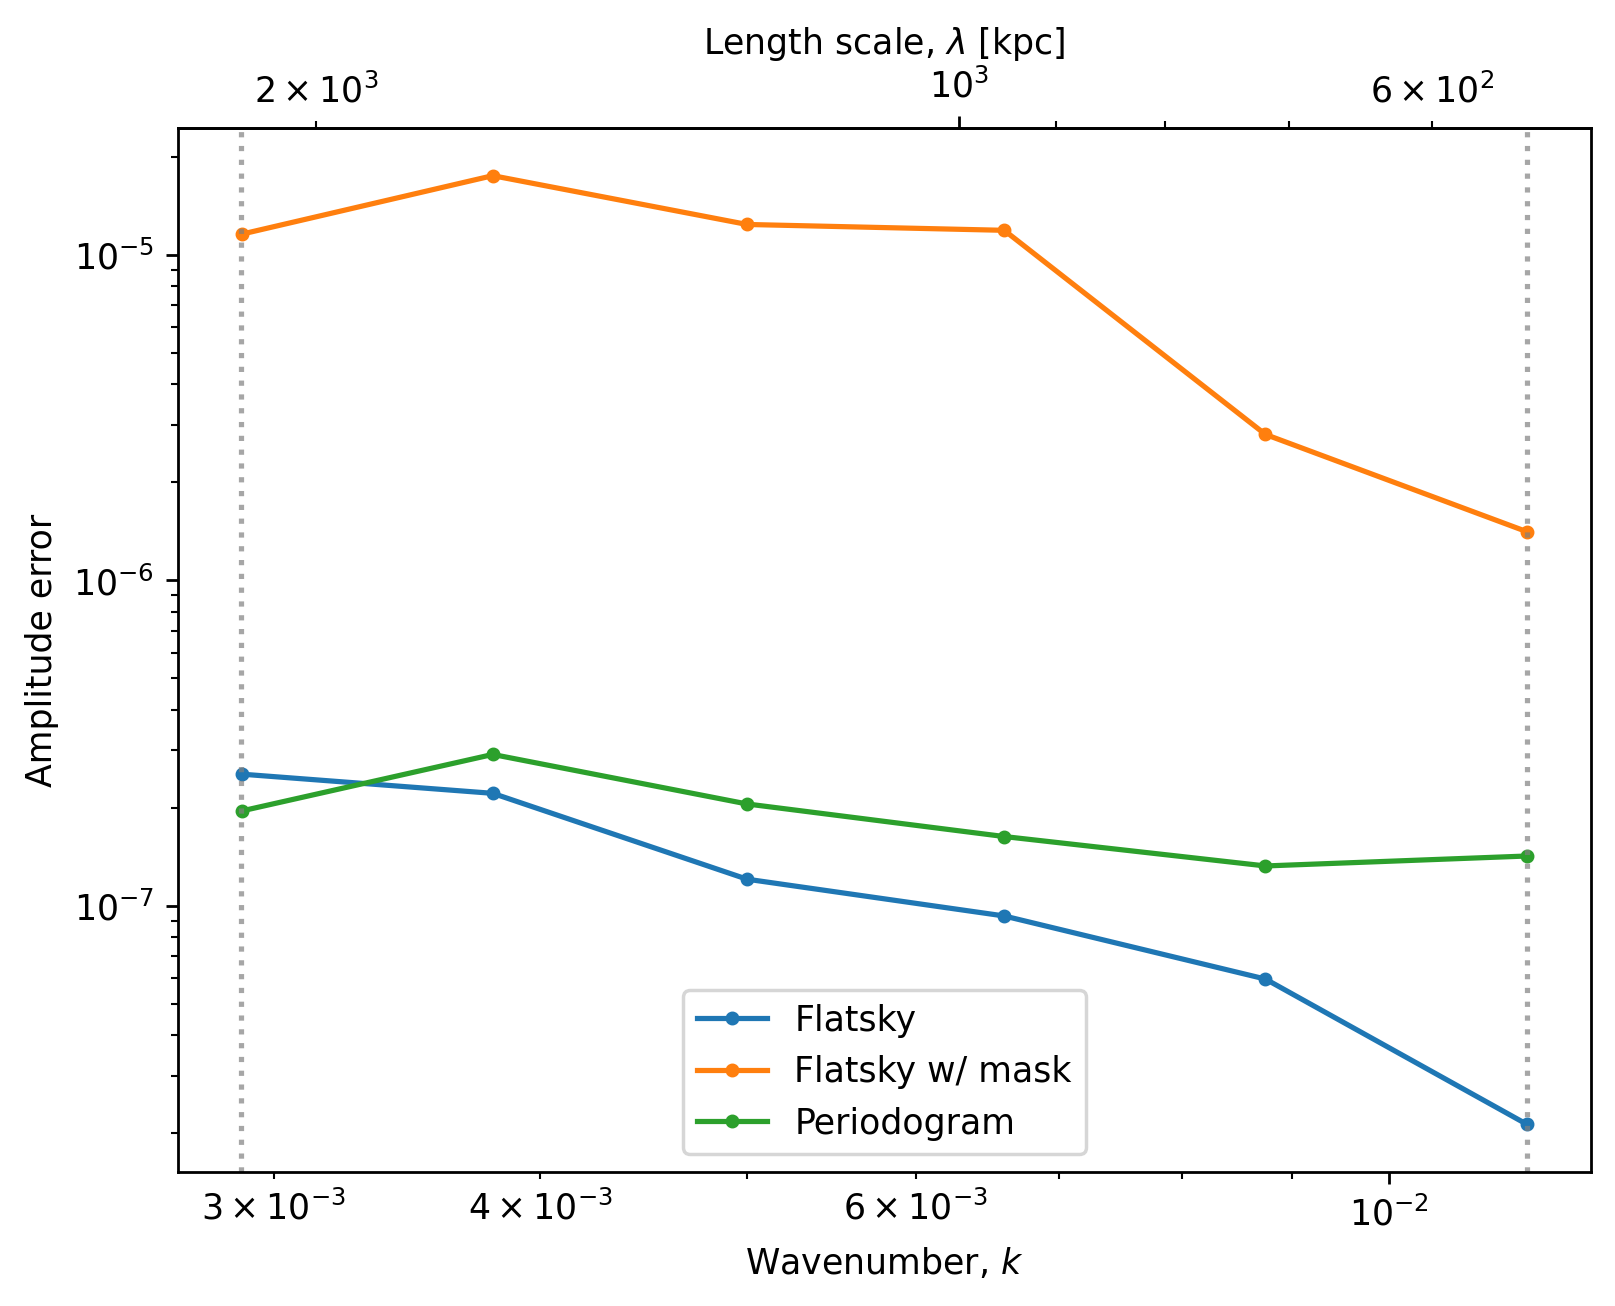

In [19]:
# plot the 'error'
fig, ax = plotting.get_fig((1, 1))
ax.plot(k1, astd1, label='Flatsky', marker='.')
ax.plot(k4, astd4, label='Flatsky w/ mask', marker='.')
ax.plot(k3, astd3, label='Periodogram', marker='.')
ax.legend()
ax.loglog()
ax.set_ylabel('Amplitude error')
ax.set_xlabel('Wavenumber, $k$')
ax.axvline(khatrix[0], linestyle=':', color='gray', alpha=0.7)
ax.axvline(khatrix[-1], linestyle=':', color='gray', alpha=0.7)
ax2 = ax.secondary_xaxis('top', functions=(k_to_l, l_to_k))
ax2.set_xlabel('Length scale, $\lambda$ [%s]' % Lcunit)

In [20]:
## NOTE: Khatri does not use equal bin widths (assuming all data is binned)
print(dkhatri)
print(db)

[0.00032123 0.00048439 0.00080716 0.00112905 0.00161036]
[0.0004  0.0005  0.0007  0.0009  0.00125 0.0016 ]
